In [460]:
using ReactionMechanismSimulator
using PyPlot
using Sundials
using SciMLBase
using QuadGK

In [461]:
outdict = readinput("chem300.rms")

Dict{Any, Any} with 4 entries:
  "Solvents"              => Solvent[Solvent("water", RiedelViscosity{Float64}(…
  Set(["surface", "gas"]) => Dict{Any, Any}("Reactions"=>ElementaryReaction[vac…
  "gas"                   => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…
  "surface"               => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…

In [462]:
boundarylayerspcs = outdict["gas"]["Species"]
boundarylayerrxns = outdict["gas"]["Reactions"]
surfspcs = outdict["surface"]["Species"]
surfrxns = outdict["surface"]["Reactions"]
interfacerxns = outdict[Set(["surface", "gas"])]["Reactions"]
solv = outdict["Solvents"][1];

In [463]:
sitedensity = 2.292e-5; # Ag111 site density is 2.292e-9 mol/cm^2 or 2.292e-5 mol/m^2
boundarylayer = IdealDiluteSolution(boundarylayerspcs,boundarylayerrxns,solv,name="boundarylayeruid",diffusionlimited=true);
surf = IdealSurface(surfspcs,surfrxns,sitedensity,name="surface");

In [464]:
# Reservoir is a 100 mL (100e-6 m^3) cell
# Proton concentration is 10^-7 mol/L (10^-4 mol/m^3)
# CO2 concentration is 0.01 mol/L (10 mol/m^3), saturation solubility ~0.03 mol/L
# AVratio in experiments is 36 m^-1 but is measured by surface area/reservoir volume
# Area of the electrode is therefore 3.6e1 m^-1 * 1e2*1e-6 m^3 = 3.6e-3 m^2 = 36 cm^2
# Assume boundary layer thickness d_bl = 1 mm or 1e-3 m
# Volume of the boundary layer V_bl = 3.6e-3 m^2 * 1e-3 m = 3.6e-6 m^3
# Actual AVratio is therefore 3.6e-3 m^2 / 3.6e-6 m^3 = 1e3 m^-1 (reciprocal of d_bl)
# Amount of sites is 2.292e-5 mol/m^2 * 1e3 m^-1 = 2.292e-2 mol/m^-3

C_proton = 1e-7*1e3;
C_co2 = 1e-2*1e3;
C_default = 1e-12;
V_res = 1000.0e-6;
AVratio = 1e3;
A_surf = 100.0e-6*36;
V_bl = A_surf/AVratio;
sites = sitedensity;

initialcondsboundarylayer = Dict(["proton"=>C_proton,
                                  "CO2"=>C_co2,
                                  "V"=>V_bl,"T"=>300,"Phi"=>0.0,"d"=>0.0]);
initialcondsreservoir = Dict(["proton"=>C_proton,
                              "CO2"=>C_co2,
                              "V"=>V_res,"T"=>300]);


# Assume voltage is -0.5 V vs. R.H.E. which equates to -0.914 V vs. S.H.E. at pH=7
initialcondssurf = Dict(["CO2X"=>0.4*sites,
        "CHO2X"=>0.1*sites,
        "CO2HX"=>0.1*sites,
        "OX"=>0.1*sites,
        "OCX"=>0.1*sites,
        "vacantX"=>0.1*sites,
        "CH2O2X"=>0.05*sites,
        "CHOX"=>0.04*sites,
        "CH2OX"=>0.01*sites,
        "A"=>A_surf,"T"=>300,"Phi"=>-1.5]);

In [465]:
domainboundarylayer, y0boundarylayer, pboundarylayer = ConstantTVDomain(phase=boundarylayer, initialconds=initialcondsboundarylayer);
domaincat,y0cat,pcat = ConstantTAPhiDomain(phase=surf,
    initialconds=initialcondssurf);

In [466]:
inter,pinter = ReactiveInternalInterfaceConstantTPhi(domainboundarylayer,
  domaincat,interfacerxns,298.15,A_surf);

In [467]:
# start with 1mm layer thickness
diffusionlayer = ConstantReservoirDiffusion(domainboundarylayer, initialcondsreservoir, A_surf, 1e-3);

In [468]:
interfaces = [inter, diffusionlayer];

In [469]:
@time react,y0,p = Reactor((domainboundarylayer,domaincat), (y0boundarylayer,y0cat), (0.0, 1e3), interfaces, (pboundarylayer,pcat,pinter));

In [470]:
@time sol = solve(react.ode,Sundials.CVODE_BDF(),abstol=1e-22,reltol=1e-8);

In [471]:
sol.t[end]

1000.0

In [472]:
sol.retcode

ReturnCode.Success = 1

In [473]:
ssys = SystemSimulation(sol,(domainboundarylayer,domaincat,), interfaces,p);

In [474]:
plotmolefractions(ssys.sims[1], 1e-8,tol=1e-25)
yscale("log")
xscale("log")

In [475]:
plotmolefractions(ssys.sims[2], 1e-8,tol=3e-2)
xscale("log")

In [476]:
concentrations(ssys.sims[1], 1e-8)

108-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  2.77777777774665e6
 27.77777777731708
  0.0
  0.0
  0.0
  0.0
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [477]:
"""
diffusive flux to the reservoir
"""
function flux_to_reservoir(sim,t,reservoirinterface)
    cs = concentrations(sim,t)
    return reservoirinterface.A .* sim.domain.diffusivity .* (cs - reservoirinterface.c) / reservoirinterface.layer_thickness
end

"""
Integrates the flux to the reservoir and computes the concentration assuming
there is no prior concentration of that species in the reservoir
"""
function get_reservoir_concentration(sim,t,reservoirinterface,Vres)
    intg,err = quadgk(x -> flux_to_reservoir(sim,x,reservoirinterface), 0, t)
    return intg./Vres
end

get_reservoir_concentration

In [478]:
flux_to_reservoir(ssys.sims[1],1e2,diffusionlayer)

108-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.010034461170647215
 1.4051622989795273e-7
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [479]:
res_cs = get_reservoir_concentration(ssys.sims[1],1e2,diffusionlayer,1.0)

108-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.0619415301880866
 1.5284178679644487e-5
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [480]:
sort(res_cs)

108-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.5284178679644487e-5
 1.0619415301880866

In [481]:
getfield.(ssys.sims[1].domain.phase.species,:name)

108-element Vector{String}:
 "Ar"
 "He"
 "Ne"
 "N2"
 "CO2"
 "proton"
 "H"
 "C=O"
 "O=CO"
 "H2O"
 ⋮
 "CCOCO"
 "CCCOO"
 "CCC"
 "CCOOC"
 "C=C=COO"
 "CC=COO"
 "C=CCO[O]"
 "COCOC"
 "COCCO"

In [482]:
getfield.(ssys.sims[2].domain.phase.species,:name)

192-element Vector{String}:
 "vacantX"
 "CO2X"
 "CHO2X"
 "CO2HX"
 "OCX"
 "OX"
 "CH2O2X"
 "CHOX"
 "CH2OX"
 "HOX"
 ⋮
 "O=CCCO[Pt]"
 "O=CCC[Pt]"
 "C=COOC#[Pt]"
 "C=CC=O.[Pt]"
 "C=C([Pt])C=O"
 "C=C(C=O)O[Pt]"
 "C=CC=[Pt]"
 "CC(O)O.[Pt]"
 "OC(O)C[Pt]"

In [483]:
# Helper function
function plotX(sim, tol, t_end, exclude)
    clf()
    xs = molefractions(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Mole Fraction")
end

plotX (generic function with 1 method)

In [484]:
# Helper function
function plotC(sim, tol, t_end, exclude)
    clf()
    xs = concentrations(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Concentration")
end

plotC (generic function with 1 method)

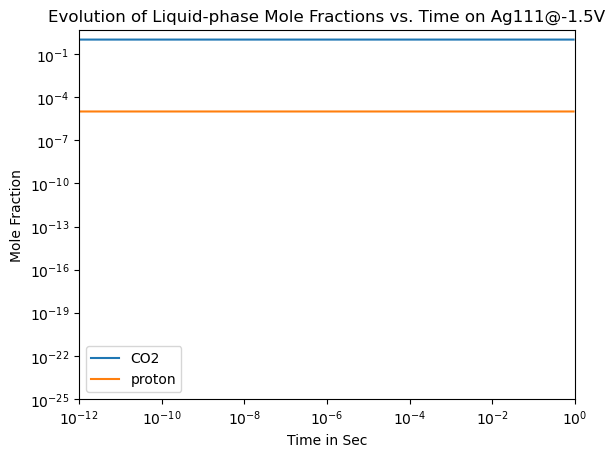

In [485]:
exclude_species = ["H2O"]
plotX(ssys.sims[1], 1e-25, 1, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1)
ylim(1e-25, 5)
title("Evolution of Liquid-phase Mole Fractions vs. Time on Ag111@-1.5V")
gcf()

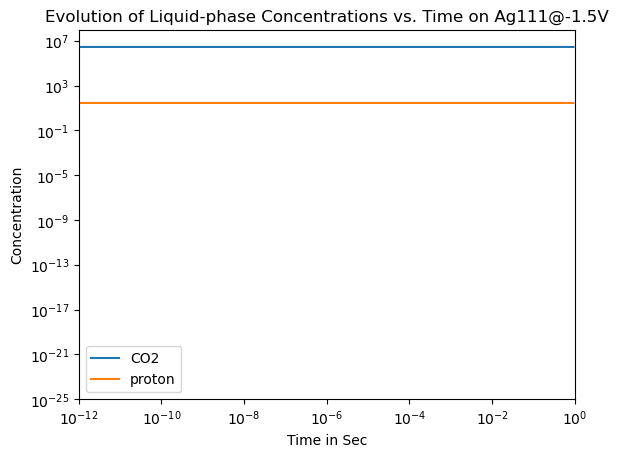

In [486]:
exclude_species = ["H2O"]
plotC(ssys.sims[1], 1e-25, 1, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1)
ylim(1e-25, 1e8)
title("Evolution of Liquid-phase Concentrations vs. Time on Ag111@-1.5V")
gcf()

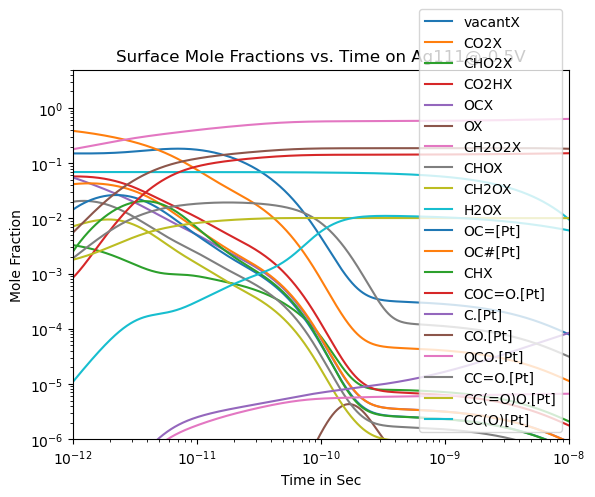

In [487]:
exclude_species = ["H2O"]
plotX(ssys.sims[2], 1e-2, 1, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1e-8)
ylim(1e-6, 5)
title("Surface Mole Fractions vs. Time on Ag111@-0.5V")
gcf()

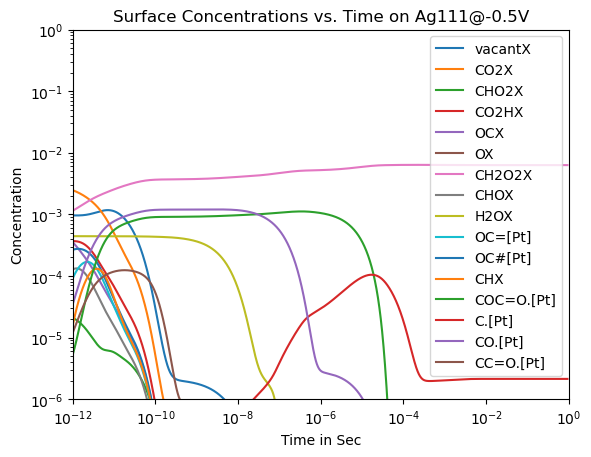

In [488]:
exclude_species = ["H2O"]
plotC(ssys.sims[2], 1e-4, 1, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1)
ylim(1e-6, 1)
title("Surface Concentrations vs. Time on Ag111@-0.5V")
gcf()

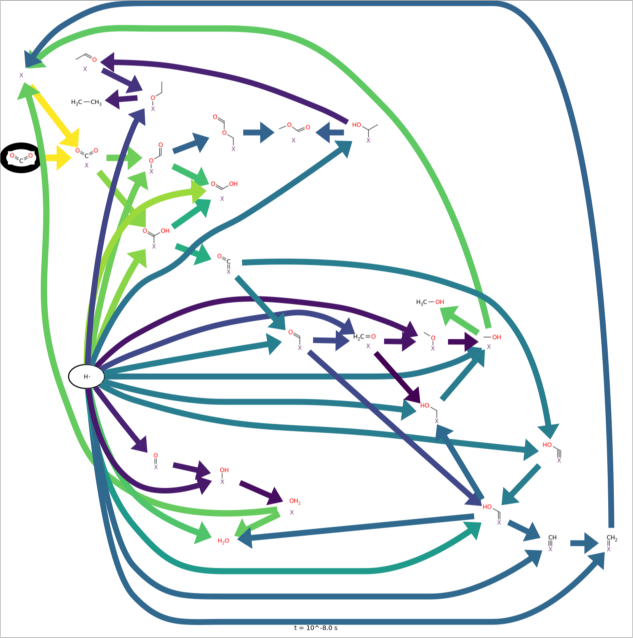

In [489]:
getfluxdiagram(ssys,1e-8;speciesratetolerance=1e-8)

In [490]:
plotrops(ssys,"CH2O2X",1e-8;N=15,tol=0.0)

In [491]:
plotrops(ssys,"CHO2X",1;N=10,tol=0.0)

In [492]:
plotrops(ssys,"CO2HX",1;N=10,tol=0.0)

In [493]:
plotrops(ssys,"OX",1;N=10,tol=0.0)

In [494]:
plotrops(ssys,"OCX",1.0e-6)

In [495]:
for (i,rxn) in enumerate(inter.reactions)
    str = getrxnstr(rxn)
    kf = inter.kfs[i]
    krev = inter.krevs[i]
    Kc = kf/krev
    println(str)
    println("kf = $kf")
    println("krev = $krev")
    println("Kc = $Kc")
end

In [496]:
rops(ssys, "CH2O2X", 1e-12)

10962-element SparseArrays.SparseVector{Float64, Int64} with 528 stored entries:
  [47   ]  =  6.5946e5
  [48   ]  =  313.674
  [49   ]  =  313.674
  [50   ]  =  0.000981642
  [53   ]  =  313.674
  [54   ]  =  313.674
  [56   ]  =  0.0059866
           ⋮
  [10084]  =  -2.72728e-17
  [10087]  =  5.81298e-21
  [10088]  =  6.43689e-15
  [10242]  =  52335.3
  [10243]  =  9.17951e5
  [10253]  =  -0.000122423
  [10264]  =  -3.78836e-5
  [10266]  =  -2.6546e-5

In [497]:
rops(ssys, "O=CO", 1e-12)

10962-element SparseArrays.SparseVector{Float64, Int64} with 17 stored entries:
  [10253]  =  0.000122423
  [10254]  =  7.35106e-6
  [10255]  =  3.75828e-24
  [10256]  =  2.03692e-27
  [10265]  =  2.56829e-9
  [10268]  =  3.27696e-15
  [10273]  =  0.157927
           ⋮
  [10310]  =  5.13479e-40
  [10352]  =  1.24697e-13
  [10540]  =  2.43596e-15
  [10555]  =  8.28092e-29
  [10835]  =  5.8637e-20
  [10865]  =  2.04153e-6
  [10867]  =  2.02897e-27
  [10908]  =  5.93896e-6